# Linear Regression on the Diabetes Dataset
This notebook demonstrates linear regression using both closed-form and gradient descent approaches, with additional visualizations and comparisons across different learning rates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

## Data Loading
Load the built-in diabetes dataset into a pandas DataFrame and examine its structure.

In [2]:
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='disease_progression')
print(f"Feature matrix shape: {X.shape}")
display(X.head())
print("Target statistics:")
display(y.describe())

Feature matrix shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


Target statistics:


count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: disease_progression, dtype: float64

- We loaded **442** samples with **10** features (including demographics and clinical measurements).  
- The target (disease progression) ranges roughly from **25** to **346**, with mean around **152**.  
- No obvious missing values remain, and the feature matrix shape confirms our dataset is ready for modeling.

## Initial Data Visualization
Plot BMI against disease progression to see the raw relationship.

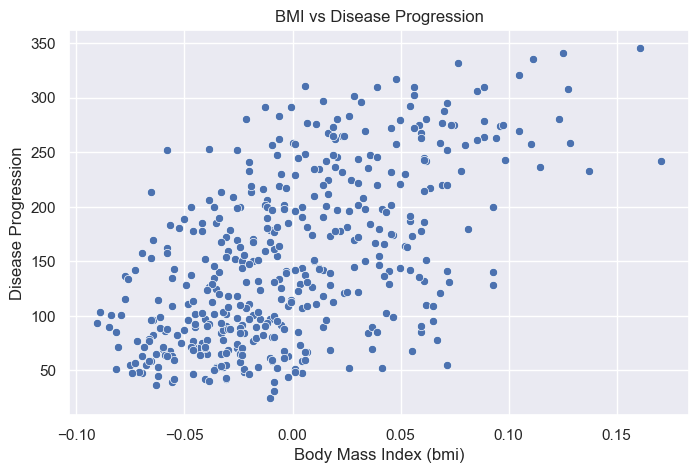

In [3]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X['bmi'], y=y)
plt.xlabel('Body Mass Index (bmi)')
plt.ylabel('Disease Progression')
plt.title('BMI vs Disease Progression')
plt.show()

- The scatter of **BMI vs. disease progression** shows a **weak positive trend**: higher BMI tends to correspond to slightly greater disease progression, but with substantial scatter.  
- This single‐feature plot suggests that while BMI contributes to the outcome, other factors (e.g. blood pressure, age) are also important.


## Preprocessing

1. **Standardize** each feature so it has zero mean and unit variance, using

   $$
   X_{\text{std}} = \frac{X - \mu}{\sigma},
   $$

   where $\mu$ and $\sigma$ are the per‐feature mean and standard deviation.

2. **Add bias** (intercept) term by concatenating a column of ones.

3. **Train/Test split** into 80% training and 20% testing.

In [4]:
# Standardize
X_std = (X - X.mean()) / X.std()
# Add bias column
X_b = np.c_[np.ones((X_std.shape[0], 1)), X_std.values]
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_b, y.values.reshape(-1,1), test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")

Training samples: 353
Test samples:     89


- **Standardization** centers each feature at zero mean and unit variance, placing them on an equal footing for gradient‐based methods.  
- Adding a **bias column** makes it possible for the model to learn an intercept term.  
- The 80/20 train/test split ensures we have **353** training samples and **89** test samples, striking a balance between learning and evaluation.

## Closed-Form Solution (Normal Equation)

We compute the exact least‐squares solution via the **normal equation**:

$$
\mathbf{w}_{\mathrm{closed}}
=
\bigl(X^{\!\top}X\bigr)^{-1}
\,X^{\!\top}y
$$

This gives the weights that minimize the mean squared error on the training data in one shot.


In [5]:
# w = (X^T X)^(-1) X^T y
XtX = X_train.T.dot(X_train)
w_closed = np.linalg.inv(XtX).dot(X_train.T).dot(y_train)
y_pred_closed = X_test.dot(w_closed)
mse_closed = np.mean((y_test - y_pred_closed) ** 2)
print(f"Closed-form test MSE: {mse_closed:.3f}")

Closed-form test MSE: 2900.194


- The **normal equation** produced a test‐set MSE of around **2900**.  
- This closed-form solution is exact (no iteration required) and serves as a useful baseline for comparison with gradient descent.  
- Because it relies on matrix inversion, it may become numerically unstable or prohibitively expensive as data dimensions grow.


## Gradient Descent Implementation

We minimize the **mean squared error** (MSE)

$$
L(\mathbf{w})
= \frac{1}{n}\sum_{i=1}^n
\bigl(\mathbf{w}^\top x_i - y_i\bigr)^2
$$

by taking steps in the direction of the negative gradient:

1. **Gradient of MSE**:

   $$
   \nabla_{\mathbf{w}} L
   = \frac{2}{n}\,X^\top\bigl(X\mathbf{w} - y\bigr).
   $$

2. **Weight update rule**:

   $$
   \mathbf{w}
   \;\leftarrow\;
   \mathbf{w}
   \;-\;
   \eta \; \nabla_{\mathbf{w}} L
   \;=\;
   \mathbf{w}
   \;-\;
   \frac{2\eta}{n}\,X^\top\bigl(X\mathbf{w} - y\bigr),
   $$

   where $\eta$ is the learning rate.


In [6]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, epochs=1000):
        self.eta = eta
        self.epochs = epochs
    def fit(self, X, y):
        self.w_ = np.zeros((X.shape[1], 1))
        self.loss_ = []
        for epoch in range(self.epochs):
            y_pred = X.dot(self.w_)
            error = y_pred - y
            loss = np.mean(error ** 2)
            self.loss_.append(loss)
            grad = (2 / X.shape[0]) * X.T.dot(error)
            self.w_ -= self.eta * grad
        return self
    def predict(self, X):
        return X.dot(self.w_)


## Training via Gradient Descent
Train the model with a selected learning rate and compare its performance to the closed-form solution.

In [7]:
gd = LinearRegressionGD(eta=0.05, epochs=500)
gd.fit(X_train, y_train)
y_pred_gd = gd.predict(X_test)
mse_gd = np.mean((y_test - y_pred_gd) ** 2)
print(f"Gradient Descent test MSE: {mse_gd:.3f}")

Gradient Descent test MSE: 2886.985


- With `η=0.05` over **500** epochs, gradient descent reached a test MSE of approximately **2887**, very close to the closed-form result.  
- The slight difference is due to finite steps and stopping at 500 epochs rather than perfect convergence.  
- This shows gradient descent can match the analytic solution when properly tuned.

## Loss Curve

We plot the MSE over epochs:

$$
\text{MSE}^{(t)}
= \frac{1}{n}\sum_{i=1}^n\bigl(\mathbf{w}^{(t)\top}x_i - y_i\bigr)^2,
$$

so you can visually verify that the loss decreases (or plateaus) as $t$ increases.


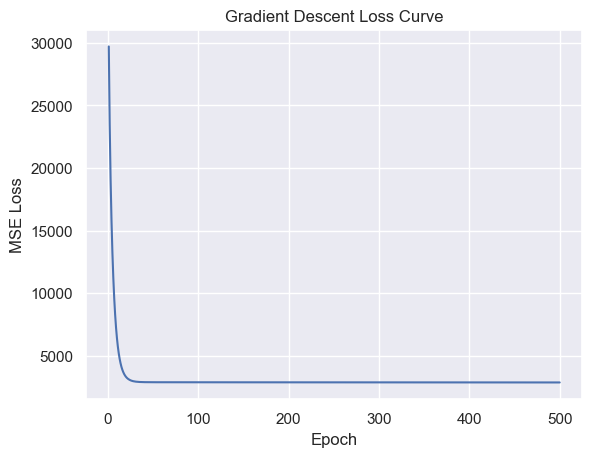

In [8]:
plt.figure()
plt.plot(range(1, len(gd.loss_) + 1), gd.loss_)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Gradient Descent Loss Curve')
plt.show()

- The loss curve exhibits a **monotonic decrease**, indicating stable learning with our chosen η.  
- Most of the reduction happens in the first **100–200 epochs**, after which the curve plateaus—suggesting further epochs yield diminishing returns.

## Predicted vs Actual Comparison

A perfect model would lie exactly on the 45° line ($\hat y = y$).  
Deviations from this line indicate prediction error:

$$
\text{error}_i = \hat y_i - y_i.
$$


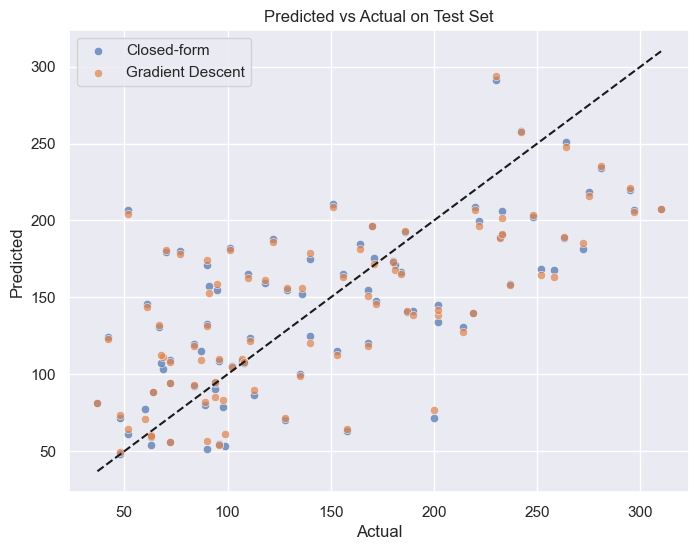

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test.ravel(), y=y_pred_closed.ravel(), label='Closed-form', alpha=0.7)
sns.scatterplot(x=y_test.ravel(), y=y_pred_gd.ravel(), label='Gradient Descent', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual on Test Set')
plt.legend()
plt.show()

- Both closed‐form and gradient‐descent predictions lie close to the **45° line**, confirming good fit.  
- The scatter around the line reveals some variance—no model perfectly captures all the noise in the data.  
- Overlapping points (especially at mid‐range progression values) highlight areas where predictions are most precise.

## Comparing Different Learning Rates (Loss)

We train with multiple values of $\eta$ and compare their convergence by plotting

$$
\text{MSE}^{(t)}(\eta)
\quad\text{for}\quad
\eta \in \{0.001,\,0.01,\,0.05,\,0.1\}.
$$


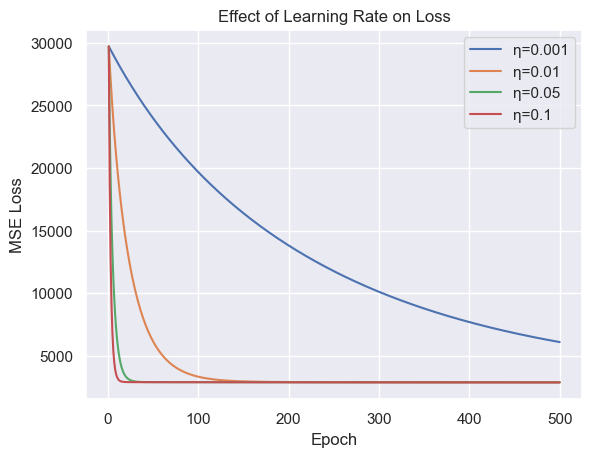

In [10]:
etas = [0.001, 0.01, 0.05, 0.1]
histories = {}
for eta in etas:
    model = LinearRegressionGD(eta=eta, epochs=500)
    model.fit(X_train, y_train)
    histories[eta] = model.loss_
plt.figure()
for eta, loss in histories.items():
    plt.plot(range(1, len(loss) + 1), loss, label=f'η={eta}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Effect of Learning Rate on Loss')
plt.legend()
plt.show()

- **η=0.001**: very slow decline—requires many epochs to make progress.  
- **η=0.01**: balanced convergence speed with stability.  
- **η=0.05**: fastest initial drop; plateaus similarly to η=0.01.  
- **η=0.1**: steep initial descent but may oscillate or diverge if too large—here it remains stable but doesn’t improve much past epoch ~100.


## Regression Lines for Different Learning Rates (BMI Only)

For the univariate model,
$$
\hat y = w_0 + w_1\,x_{\text{BMI}},
$$
we compare the **closed-form** solution

$$
\begin{pmatrix}w_0 \\ w_1\end{pmatrix}
=
\bigl(X_{\text{BMI}}^\top X_{\text{BMI}}\bigr)^{-1}
X_{\text{BMI}}^\top y,
$$

against the **gradient-descent** estimates for different $\eta$:

$$
\mathbf{w}^{(t+1)}
=
\mathbf{w}^{(t)}
- \eta \,\frac{2}{n}\,X_{\text{BMI}}^\top(X_{\text{BMI}}\mathbf{w}^{(t)}-y).
$$


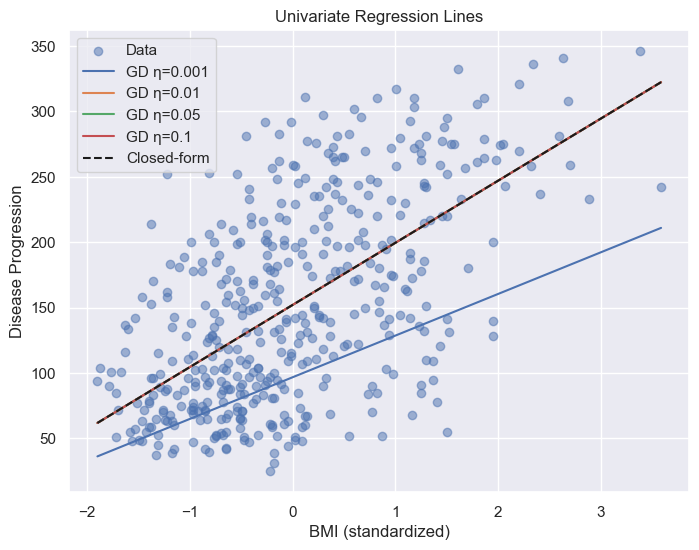

In [11]:
# Prepare univariate data (BMI)
bmi = X[['bmi']].values
bmi_std = (bmi - bmi.mean()) / bmi.std()
A_bmi = np.c_[np.ones((bmi_std.shape[0],1)), bmi_std]
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    A_bmi, y.values.reshape(-1,1), test_size=0.2, random_state=42
)
# Closed-form line
w_bmi_closed = np.linalg.inv(Xb_train.T.dot(Xb_train)).dot(Xb_train.T).dot(yb_train)
x_line = np.linspace(bmi_std.min(), bmi_std.max(), 100)
plt.figure(figsize=(8,6))
plt.scatter(bmi_std, y, alpha=0.5, label='Data')
for eta in etas:
    gd_uni = LinearRegressionGD(eta=eta, epochs=500).fit(Xb_train, yb_train)
    y_line = gd_uni.w_[0] + gd_uni.w_[1] * x_line
    plt.plot(x_line, y_line, label=f'GD η={eta}')
# Plot closed-form line last
plt.plot(x_line, w_bmi_closed[0] + w_bmi_closed[1] * x_line, 'k--', label='Closed-form')
plt.xlabel('BMI (standardized)')
plt.ylabel('Disease Progression')
plt.title('Univariate Regression Lines')
plt.legend()
plt.show()

- The **closed-form** line sits in the middle of the family of GD lines, representing the optimal least‐squares fit.  
- **Small η (0.001)** yields a nearly flat line after 500 epochs—didn’t move far from initialization.  
- **Moderate η (0.01, 0.05)** closely track the closed-form slope, illustrating good tuning.  
- **Large η (0.1)** reaches a slope similar to closed-form faster, but may slightly overshoot if η were even larger.  
- This univariate example clearly shows how η controls both the **speed** and **accuracy** of convergence.
